<a href="https://colab.research.google.com/github/SudeepSarkar/sarkar-computer-vision-lectures/blob/main/CV_Module_4_3_2D_Linear_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright (c) 2021, Sudeep Sarkar, University of South Florida, Tampa

# Topics covered

* Estimation of linear transforms between two images that are also linear in terms of their parameters, e.g., affine.

* Linear transform: $T(a x + y) = a T(x) + T(y)$

* Linear transform that is non-linear in terms of parameter ($\theta$): $T(x) = x cos (\theta)$

* Linear transform that is linear in terms of parameter ($\omega$): $T(x) = \omega x $

* How to code up the estimation process without for-loops.

* Sensitivity of the estimation process to correspondence errors

## Code: Initialize notebook

In [2]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Colab Notebooks/CAP 6415 Computer Vision Online/data/'
!ls "$data_dir"


Mounted at /content/drive
 0005_Walking001.xlsx			     left01.jpg
 0008_ChaCha001.xlsx			     left02.jpg
 2011_09_26_drive_0048_sync		     left03.jpg
 2011_09_26_drive_0048_sync.zip		     left04.jpg
 20211003_082148.jpg			     left05.jpg
 20211003_082201.jpg			     left06.jpg
 apple.jpg				     left07.jpg
'Armes 1.png'				     left08.jpg
'Armes 2.png'				     left09.jpg
 blog_danforth_monica_mural_panorama.jpg     left11.jpg
 blog_monica_mural_brown_white.jpg	     left12.jpg
 blog_monica_mural_fish_tree_windows1.jpg    lizard.jpg
'cats and dogs.jpg'			     MOT16-08-raw.webm
 convenience-store-cereal01.jpg		     mountain_peak_1.png
 declaration_of_independence_stone_630.jpg   mountain_peak_2.png
 Fig3_3a.jpg				     parking_lot_meva_1.png
 Fig3_4a.jpg				     parking_lot_meva_2.png
 Fig3_4c.jpg				     parking_lot_meva_3.png
 hawaii.png				    'Road Signs Kaggle'
 house_1.png				     semper
 house_2.png				    'Superbowl 2021_1.png'
 house_facade.png			    'Superbowl 2021_2.png'
 IMG_01

In [3]:
import numpy as np
import torch

import matplotlib.pyplot as plt
import scipy.ndimage as scimage
import torch.nn as nn

# need to install this version of opencv so that we have access to SIFT
# which is now outside patent protection
!pip install opencv-contrib-python==4.4.0.44
import cv2
print (cv2 .__version__)

np.set_printoptions(precision=2, suppress=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 MB 15.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.6.0.66
    Uninstalling opencv-contrib-python-4.6.0.66:
      Successfully uninstalled opencv-contrib-python-4.6.0.66
4.4.0


# Two notions of linearity

1. With respect to the **input space**

    * A transform $\mathbf{y} = \mathbf{f}(\mathbf{x})$ is **linear** if and only if $\mathbf{f}(\mathbf{x_1} + \mathbf{x_2}) = \mathbf{f}(\mathbf{x_1}) + \mathbf{f}(\mathbf{x_2})$

    * Which of these transforms $g_1(x)$ and $\mathbf{g_2}(\mathbf{x})$  are linear?

    \begin{eqnarray}
    y & = g_1(x) = & a x + b \\
    \begin{bmatrix}
    y \\ 1
    \end{bmatrix}  & = \mathbf{g_2}(\mathbf{x}) = &
    \begin{bmatrix}
    a & b \\
    0 & 1
    \end{bmatrix}
    \begin{bmatrix}
    x \\ 1
    \end{bmatrix}
    \end{eqnarray}

    * Note how we have turned a non-linear transformation into a linear one using homogenous coordinates. However, this is **not** possible for all non-linear transformations.

    * Note that we have defined this concept of the linear transformation for the domain of operation, the input vectors. All the geometric transformations we have studied, except for projective, are linear with respect to the input vectors. 

2. With respect to the **parameters**

    * There is another concept of linearity that is related to the parameters of the transformation. For example, the 2D rotation is a linear transformation but is non-linear with respect to the parameter, $\theta$ - the rotation angle.

* We will consider the affine transformation in this notebook, which is a linear transformation and is also **linear with respect to the parameters**.

* But first, we consider a more straightforward example.

# Estimation of 1D Transform


* Consider the transformation: $y = f(x) = (a + 1) x + b$. 
    * Note how we have parameterized the transform: when $a = b = 0$, $y = x$, i.e. it is the *identity* transform.

* Problem: Given samples $\{(x_1, y_1), \cdots, (x_n, y_n)\}$, estimate $a$ and $b$

* For any given $(a, b)$, the error for the $i$-th point (also called residual): 

\begin{equation}
r_i = (y_i - (a + 1) x_i - b)
\end{equation}

* Total **sum of squared errors** (also called L2 error): 

\begin{equation}
r = \sum_i r_i^2 = \sum_i (y_i - (a + 1) x_i - b)^2
\end{equation}

* Find values of $a$ and $b$ that **minimizes** $r$.

* The derivatives with respect to $a$ and $b$ are zero at the minimum point.

* These error derivatives are as follows:

\begin{eqnarray}
\frac{\partial}{\partial a} r & = & 0 \\
\sum_i - 2 (y_i - a x_i - x_i - b) x_i & = & 0 \\
\sum_i (-y_i + a x_i + x_i + b) x_i & = & 0 \\
\sum_i -y_i x_i + a x_i^2 + x_i^2 + b x_i & = & 0 \\
a (\sum_i x_i^2) + b (\sum_i x_i) - \sum_i (y_i - x_i) x_i  & = & 0
\end{eqnarray}

* The derivative with respect to $b$ is as follows:

\begin{eqnarray}
\frac{\partial}{\partial b} r & = & 0 \\
\sum_i -2 (y_i - a x_i - x_i - b) & = & 0 \\
\sum_i (-y_i + a x_i + x_i + b) & = & 0 \\
\sum_i -y_i + a x_i + x_i + b& = & 0 \\
a (\sum_i x_i) + b (\sum_i 1) - \sum_i (y_i - x_i)  & = & 0
\end{eqnarray}

* We have two equations for two unknowns, $a$, and $b$. We can rewrite them as matrices.



* Expressing these equations in matrix form, we have:

\begin{eqnarray}
\begin{bmatrix}
\sum_i x_i^2 & \sum_i x_i \\
\sum_i x_i &  N \\
\end{bmatrix} 
\begin{bmatrix}
a \\ b
\end{bmatrix} & = & 
\begin{bmatrix}
\sum_i (y_i - x_i) x_i \\ \sum_i (y_i  - x_i)
\end{bmatrix} \\
\begin{bmatrix}
a \\ b
\end{bmatrix} & = &  
\begin{bmatrix}
\sum_i x_i^2 & \sum_i x_i \\
\sum_i x_i &  N \\
\end{bmatrix}^{-1}
\begin{bmatrix}
\sum_i (y_i - x_i) x_i \\ \sum_i (y_i  - x_i)
\end{bmatrix}
\end{eqnarray}

* Or compactly:
\begin{eqnarray}
\mathbf{H} \mathbf{p} & = & \mathbf{b}  \\
\mathbf{p} & = & \mathbf{H}^{-1} \mathbf{b}
\end{eqnarray}



# Assignment: Computing H without for loops

Write python code to compute $\mathbf{H}$ and $\mathbf{b}$ given samples $\{(x_1, y_1), \cdots, (x_n, y_n)\}$ **without** for-loops.

>> def compute_H (X, Y) : -- returns 2 by 2 matrix H

>> def compute_b (X, Y) : -- returns 2 by 1 matrix b

X is an np.array of size N by 1, and Y is an np.array of size N by 1. They store the x and y values in correspondence order; X [i] is associated with Y[i]. 

Write code to also test your implementation by using synthetic data generated using known noisy model and estimating the parameters.



## Code: Starting point - corresponding points using SIFT

The starting point of the estimation is the set of corresponding pairs of points between two images. There are many ways to compute these correspondences. Here we use the OpenCV solution using SIFT features and descriptors, which works well in many circumstances.

In [1]:
from skimage import io

# ------------Read images-----------------------------------
image_1 = io.imread('https://i.stack.imgur.com/Er7vx.png')
image_2 = io.imread('https://i.stack.imgur.com/gAz96.png')
NUM_MATCHES = 8

print("Input image size:", image_1.shape)

#-------------Detect SIFT features--------------------------
sift = cv2.SIFT_create(nOctaveLayers = 3, contrastThreshold = 0.04, edgeThreshold = 10, sigma = 1.6)
keypoints_1, descriptors_1 = sift.detectAndCompute(image_1, None)
keypoints_2, descriptors_2 = sift.detectAndCompute(image_2, None)

# -------------Match SIFT features--------------------------
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
matches = bf.match(descriptors_1, descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)
# extract list of corresponding point location pairs
X_1 = []
X_2 = []
for i in range(NUM_MATCHES) :
    X_1.append([keypoints_1[matches[i].queryIdx].pt[0], keypoints_1[matches[i].queryIdx].pt[1]])
    X_2.append([keypoints_2[matches[i].trainIdx].pt[0], keypoints_2[matches[i].trainIdx].pt[1]])
X_1 = np.array(X_1)
X_2 = np.array(X_2)

#----------------------------------Display-------------------------------------------------------
# create an visualization on the matched on an image
match_image = cv2.drawMatches(image_1, keypoints_1, image_2, keypoints_2, matches[0:NUM_MATCHES], image_2, flags=2)

plt.figure(figsize=(40,20))
plt.subplot(221)
plt.imshow(image_1, 'gray')
plt.plot(X_1[:,0], X_1[:,1], 'bo')
plt.subplot(222)
plt.imshow(image_2, 'gray')
plt.plot(X_2[:,0], X_2[:,1], 'ro')
plt.subplot(212)
plt.imshow(match_image);

Input image size: (223, 324)


NameError: ignored

# Estimation of **Linear** 2D Transformations (Affine)


* We will denote a transformation compactly using homogenous coordinates as:

\begin{equation}
   \tilde{\mathbf{x_i}}' =  \mathbf{f} (\tilde{\mathbf{x_i}}; \mathbf{p})
\end{equation}

>> where $\mathbf{p}$ is the set of parameters to be estimated.
    
* For affine transformation, this function is given by 

    \begin{eqnarray}
        \mathbf{f} (\tilde{\mathbf{x_i}}; \mathbf{p}) = 
    \begin{bmatrix}
        f_x \\ f_y \\ 1
    \end{bmatrix} 
        & = & 
        \begin{bmatrix}
            1+a_{00} & a_{01} & t_x \\
            a_{10} & 1+a_{11} & t_y \\
            0  & 0 & 1
        \end{bmatrix} 
        \begin{bmatrix}
            x_i \\ y_i \\ 1
        \end{bmatrix}
    \end{eqnarray}

    * For the numerical convenience of choosing initialization, we usually reparameterize the transformations so that **when the parameters, $\mathbf{p}$, are all zero, the point does not move**, i.e., we have the identity transformation. 

* The parameter vector is six-dimensional 
$\mathbf{p} = 
\begin{bmatrix}
    a_{00} \\ a_{01} \\ t_x \\ a_{10} \\ a_{11} \\ t_y
\end{bmatrix}$. 

* Given a set of corresponding points between two images, $\{(\tilde{\mathbf{x_i}}', \tilde{\mathbf{x_i}})|i=1, \cdots N\}$ find the transformation between them. 


* We next derive an expression that relates the residual error with the disparity *for one point*. We will then sum this quantity over all the points to arrive at the total residual.
    

# The error (residual) for the $i$-th pair of corresponding points

* The error (residual) of the $i$-th point pairs is given by 

\begin{eqnarray}
    \mathbf{r}_i & = & f (\tilde{\mathbf{x_i}}; \mathbf{p}) - \tilde {\mathbf{x_i}}^{'} = 
    \begin{bmatrix}
        - \\ -
    \end{bmatrix}\\
    \mathbf{r}_i & = & \begin{bmatrix}
        a_{00}+1 & a_{01} & t_x \\
        a_{10} & a_{11} + 1 & t_y \\
        0  & 0 & 1
    \end{bmatrix} \begin{bmatrix}
        x_i \\ y_i \\ 1
    \end{bmatrix} - \begin{bmatrix}
        x_i' \\ y_i' \\ 1
    \end{bmatrix}\\
    & = & \left ( \begin{bmatrix}
        a_{00} & a_{01} & t_x \\
        a_{10} & a_{11} & t_y \\
        0  & 0 & 0
    \end{bmatrix} + \begin{bmatrix}
        1 & 0 & 0 \\
        0 & 1 & 0 \\
        0  & 0 & 1
    \end{bmatrix} \right ) \begin{bmatrix}
        x_i \\ y_i \\ 1
    \end{bmatrix} - \begin{bmatrix}
        {x}_i' \\ y_i' \\ 1
    \end{bmatrix}\\
    & = & 
    \begin{bmatrix}
        a_{00} & a_{01} & t_x \\
        a_{10} & a_{11} & t_y \\
        0  & 0 & 0
    \end{bmatrix} 
    \begin{bmatrix}
        x_i \\ y_i \\ 1
    \end{bmatrix}  - 
    \begin{bmatrix}
        x_i' - x_i\\ y_i' - y_i \\ 0
    \end{bmatrix} \\
        & = & 
    \begin{bmatrix}
        a_{00} & a_{01} & t_x \\
        a_{10} & a_{11} & t_y 
    \end{bmatrix} 
    \begin{bmatrix}
        x_i \\ y_i \\ 1
    \end{bmatrix}  - 
    \begin{bmatrix}
        x_i' - x_i\\ y_i' - y_i 
    \end{bmatrix} \\
\end{eqnarray}
\begin{eqnarray}
    \mathbf{r}_i^{2 \times 1}  & = & 
    \begin{bmatrix}
        x_i & y_i & 1 & 0 & 0 & 0\\
        0   & 0 & 0  & x_i & y_i & 1
    \end{bmatrix}
    \begin{bmatrix}
        a_{00} \\ a_{01} \\ t_x \\ a_{10} \\ a_{11} \\ t_y 
    \end{bmatrix}  - 
    \begin{bmatrix}
        x_i' - x_i\\ y_i' - y_i 
    \end{bmatrix} \\
        & = & \mathbf{J_i} \mathbf{p} - \Delta \mathbf{x_i}
\end{eqnarray}

* Note that $\Delta \mathbf{x_i} = (\mathbf{x_i}' - \mathbf{x_i})$ is the difference between initial and new point. This is also called the *disparity*.

* And, the 2 by 6 matrix  $ \mathbf{J_i}$ is given by

\begin{equation}
\color{red}{\mathbf{J_i} = \begin{bmatrix}
        x_i & y_i & 1 & 0 & 0 & 0\\
        0   & 0 & 0  & x_i & y_i & 1
    \end{bmatrix}}
\end{equation}

# Total residual

* The total error is given by the sum of the squared residuals (also known as the L2 norm).  

* Note: There are other possible forms for the total error, such as the sum of absolute values of the residual (L1 norm) or weighted L2 norms (robust estimators).

\begin{eqnarray}
    r & = & \sum_i || \mathbf{r}_i||^2 \\
    & = & \sum_i \mathbf{r}_i^T \mathbf{r}_i = \sum_i \begin{bmatrix}
        - & -
    \end{bmatrix}\begin{bmatrix}
        - \\ -
    \end{bmatrix} \\
    & = & \sum_i \left ( \mathbf{J_i} \mathbf{p} - \Delta \mathbf{x_i} \right )^T \left ( \mathbf{J_i} \mathbf{p} - \Delta \mathbf{x_i} \right ) \\
    & = & \sum_i \left ( \mathbf{p}^T \mathbf{J_i}^T - \Delta \mathbf{x_i}^T \right ) \left ( \mathbf{J_i} \mathbf{p} - \Delta \mathbf{x_i} \right ) \\
    & = & \sum_i \mathbf{p}^T \mathbf{J_i}^T \mathbf{J_i} \mathbf{p} - 2 \mathbf{p}^T \mathbf{J_i}^T \Delta \mathbf{x_i} + \Delta \mathbf{x_i}^T \Delta \mathbf{x_i} \\
    & = & \mathbf{p}^T \left ( \color{red}{\sum_i  \mathbf{J_i}^T \mathbf{J_i}} \right) \mathbf{p} - 2 \mathbf{p}^T \left (\color{red}{ \sum_i \mathbf{J_i}^T \Delta \mathbf{x_i}}\right )  + \sum_i \Delta \mathbf{x_i}^T \Delta \mathbf{x_i} \\
     & & \\
    & = & \color{red}{\mathbf{p}^T \mathbf{H}^{6 \times 6} \mathbf{p} - 2 \mathbf{p}^T \mathbf{b}^{6 \times 1}  + c} \\
    & = & \begin{bmatrix}
        ? & ? & ? & ? & ? & ? \\
    \end{bmatrix}
    \begin{bmatrix}
        - & - & - & - & - & - \\
        - & - & - & - & - & - \\
        - & - & - & - & - & - \\
        - & - & - & - & - & - \\
        - & - & - & - & - & - \\
        - & - & - & - & - & - 
    \end{bmatrix}
    \begin{bmatrix}
        ? \\ ? \\ ? \\ ? \\ ? \\ ? 
    \end{bmatrix}  \\
    &  & - 2 \begin{bmatrix}
        - & - & - & - & - & - \\
    \end{bmatrix}
    \begin{bmatrix}
            ? \\ ? \\ ? \\ ? \\ ? \\ ? 
    \end{bmatrix} + \begin{bmatrix}
        -
    \end{bmatrix}
\end{eqnarray}

# Linear Solution

The residual, $r$, is given by:

\begin{equation}
r  =  \mathbf{p}^T \mathbf{H}^{6 \times 6} \mathbf{p} - 2 \mathbf{p}^T \mathbf{b}^{6 \times 1}  + c
\end{equation}

To find the minimum of the total residual, we take a derivative with respect to the parameters and set it to zero.
    
\begin{eqnarray}
    \frac{\partial r}{\partial \mathbf{p}} & = & 0 \\
    \mathbf{H} \mathbf{p}  & = &\mathbf{b} \\
    \color{red}{\mathbf{p}}  & \color{red}{=} & \color{red}{\mathbf{H}^{-1} \mathbf{b}}
\end{eqnarray}
    
When does the inverse exist? What is the minimum number of point correspondences we need?
    
* **Advanced Material:** Instead of the inverse (or pseudo-inverse), solving this via [QR decomposition](https://en.wikipedia.org/wiki/QR_decomposition) is more stable than the inverse-based solution above. The pseudo-inverse is numerically unstable if the lowest eigenvalue is close to zero. In other words, the minimization problem has multiple solutions, and it is ill-conditioned. This condition could be the case if points are clustered together, i.e., not spread out across the region of interest. Such clustering is less likely to happen in the current problem of computing affine transformations between point sets. Still, it can occur in other settings where we must compute the linear least-squares estimate. **Hence, solving via QR decomposition is something you need to know and keep in mind as an option.** 

\begin{eqnarray}
    \mathbf{H} \mathbf{p}  & = &\mathbf{b} \\
    \mathbf{Q} \mathbf{R}\mathbf{p}  & = &\mathbf{b} \\
    \mathbf{R}\mathbf{p}  & = & \mathbf{Q}^T \mathbf{b}
\end{eqnarray}
    
>> where $\mathbf{Q}$ is an orthonormal matrix, $\mathbf{Q}\mathbf{Q}^T = \mathbf{I}$ and $\mathbf{R}$ is an upper triangular matrix. The solution for $\mathbf{p}$ is constructed by working the upper triangular matrix from the last row upwards towards the first row.
    
> QR decomposition is the basis of more complex algorithms, such as computing the inverse, SVD, and eigenvalue decompositions. **Unlike the SVD and eigenvalue decompositions, QR factorization does not require iteration and can be computed precisely in $\mathcal{O}(MN^2 + N^3)$ operations for a $M \times N$ matrix.** 

# The form of the matrix $\mathbf{H}$ 

\begin{eqnarray}
    \mathbf{H} & = & \sum_i  \mathbf{J_i}^T \mathbf{J_i} \\
    & = & \sum_i \begin{bmatrix}
        x_i & 0 \\
        y_i & 0 \\
        1 & 0 \\
        0 & x_i \\
        0 & y_i \\
        0 & 1 \\
        \end{bmatrix} \begin{bmatrix}
         x_i & y_i & 1 &  0 & 0 & 0 \\
         0   & 0   &0 &  x_i & y_i & 1
        \end{bmatrix} \\
    & = & \sum_i 
    \begin{bmatrix}
    x_i^2 & x_i y_i & x_i & 0 & 0 & 0 \\
    x_i y_i & y_i^2 & y_i & 0 & 0 & 0 \\
    x_i & y_i & 1 & 0 &  0 & 0 \\
    0 & 0 & 0 & x_i^2 & x_i y_i & x_i \\
    0 & 0 & 0 & x_i y_i & y_i^2 & y_i \\
    0 & 0 & 0 & x_i & y_i & 1
    \end{bmatrix} \\
    & = &
    \begin{bmatrix}
    \sum_i x_i^2 & \sum_i x_i y_i & \sum_i x_i & 0 & 0 & 0 \\
    \sum_i x_i y_i & \sum_i y_i^2 & \sum_i y_i & 0 & 0 & 0 \\
    \sum_i x_i & \sum_i y_i & N & 0 &  0 & 0 \\
    0 & 0 & 0 & \sum_i x_i^2 & \sum_i x_i y_i & \sum_i x_i \\
    0 & 0 & 0 & \sum_i x_i y_i & \sum_i y_i^2 & \sum_i y_i \\
    0 & 0 & 0 & \sum_i x_i & \sum_i y_i & N
    \end{bmatrix}
\end{eqnarray}
    

# The form of the vector $\mathbf{b}$ 


\begin{eqnarray}
    \mathbf{b} & = &  \sum_i \mathbf{J_i}^T \Delta \mathbf{x_i} \\
    & = & \sum_i 
    \begin{bmatrix}
        x_i & 0 \\
        y_i & 0 \\
        1 & 0 \\
        0 & x_i \\
        0 & y_i \\
        0 & 1 
    \end{bmatrix} 
    \begin{bmatrix}
        \Delta x_i \\ \Delta y_i
    \end{bmatrix} \\
    & = & 
    \begin{bmatrix}
        \sum_i x_i \Delta x_i \\
        \sum_i y_i \Delta x_i \\
        \sum_i \Delta x_i \\
        \sum_i x_i \Delta y_i \\
        \sum_i y_i \Delta y_i \\
        \sum_i \Delta y_i 
    \end{bmatrix}
\end{eqnarray}

# Computing the $\mathbf{H}$ and $\mathbf{b}$ using matrix operations without for-loops

* The constructing the matrix $\mathbf{H}$ and the vector $\mathbf{b}$ requires the summation of the given point pairs. Can we do this **without** for-loops?

* Let the corresponding pairs of points be stored in the two matrices, as shown below. The columns in the two matrices keep the corresponding pairs of points.

\begin{equation}
\mathbf{X} = \begin{bmatrix}
    x_1 & x_2 & \cdots & x_N \\
    y_1 & y_2 & \cdots & y_N \\
    1   &  1  & \cdots & 1 
\end{bmatrix},  \mathbf{X'} = \begin{bmatrix}
    x_1' & x_2' & \cdots & x_N' \\
    y_1' & y_2' & \cdots & y_N' \\
    1   &  1  & \cdots & 1 
\end{bmatrix}
\end{equation}

* If we multiply the coordinates of one set as $\mathbf{X} \mathbf{X}^T$, we end up with a 3 by 3 matrix, as shown below. This matrix is the moment matrix.

\begin{eqnarray}
\mathbf{X}  \mathbf{X}^T & = & 
\begin{bmatrix}
    x_1 & x_2 & \cdots & x_N \\
    y_1 & y_2 & \cdots & y_N \\
    1   &  1  & \cdots & 1 
\end{bmatrix} 
\begin{bmatrix}
    x_1 & y_1 & 1 \\
    x_2 & y_2 & 1 \\
    \vdots \\
    x_N & y_N& 1
\end{bmatrix} \\
& = & 
\begin{bmatrix}
\sum_i x_i^{2} & \sum_i x_i y_i & \sum_i x_i  \\
    \sum_i x_i y_i & \sum_i y_i^2 & \sum_i y_i  \\
    \sum_i x_i & \sum_i y_i & N & \\
\end{bmatrix}
\end{eqnarray}

* If you compare this 3 by 3 matrix with the expression for $\mathbf{H}$ for this problem, we see that

\begin{equation}
\mathbf{H} = 
\begin{bmatrix}
\mathbf{X}  \mathbf{X}^T & \mathbf{0}^{3 x 3} \\
\mathbf{0}^{3 x 3} & \mathbf{X}  \mathbf{X}^T 
\end{bmatrix}
\end{equation}

* We can also compute the vector $\mathbf{b}$ in a similar manner. We store the displacement/disparity/discrepancy between the corresponding points in the following matrix. 

\begin{eqnarray}
    \Delta \mathbf{X}^{2 \times N} & = & 
    \left (\mathbf{X'} - \mathbf{X} \right) 
\end{eqnarray}

* Now consider the product $ \mathbf{X} (\Delta \mathbf{X})^T$.

\begin{eqnarray}
\mathbf{X} (\Delta \mathbf{X})^T & = & 
\begin{bmatrix}
    x_1 & x_2 & \cdots & x_N \\
    y_1 & y_2 & \cdots & y_N \\
    1   &  1  & \cdots & 1 
\end{bmatrix} 
\begin{bmatrix}
    x_1^{'} - x_1 &  y_1^{'} - y_1 & 0 \\
    x_2^{'} - x_2 &  y_2^{'} - y_2 & 0\\
    \vdots & \vdots & \vdots\\
    x_N^{'} - x_N &  y_N^{'} - y_N & 0
\end{bmatrix} \\
& = & 
\begin{bmatrix}
\sum_i x_i (x_i^{'} - x_i) & \sum_i x_i (y_i^{'} - y_i) & 0 \\
\sum_i y_i (x_i^{'} - x_i) & \sum_i y_i (y_i^{'} - y_i) & 0 \\
\sum_i (x_i^{'} - x_i) & \sum_i (y_i^{'} - y_i) & 0 \\
\end{bmatrix} \\
& = & 
\begin{bmatrix}
\sum_i x_i \Delta x_i & \sum_i x_i \Delta y_i  & 0 \\
\sum_i y_i \Delta x_i  & \sum_i y_i \Delta y_i  & 0 \\
\sum_i \Delta x_i & \sum_i \Delta y_i  & 0 \\
\end{bmatrix} \\
\end{eqnarray}

* If we compare the form of the vector $\mathbf{b}$ we had derived earlier, you will see that it can be constructed from the above 3 by 3 matrix by stacking the first two columns. 

## Code: Computing $\mathbf{H}$ and $\mathbf{b}$

In [ ]:
X = np.row_stack((X_1.transpose(1,0), np.ones((1, X_1.shape[0]))))
print('X_1=\n', X_1, '\nX=\n', X)

X_dash = np.row_stack((X_2.transpose(1,0), np.ones((1, X_2.shape[0]))))
print('X_2=\n', X_2, '\nX_dash=\n', X_dash)

M = X @ X.transpose(1,0)
H1 = np.column_stack((M, np.zeros((3,3))))
H2 = np.column_stack((np.zeros((3,3)), M))
H = np.row_stack((H1, H2))
print('H =\n', H)

b_dash = X @ (X_dash - X).transpose(1,0)
b = np.row_stack((b_dash[:,0][:,None], b_dash[:,1][:,None]))
print('b =\n', b)

X_1=
 [[240.45 116.58]
 [164.62  77.97]
 [247.45 169.25]
 [230.19 127.66]
 [215.96 190.95]
 [208.33 161.66]
 [256.41 166.98]
 [210.07 154.61]] 
X=
 [[240.45 164.62 247.45 230.19 215.96 208.33 256.41 210.07]
 [116.58  77.97 169.25 127.66 190.95 161.66 166.98 154.61]
 [  1.     1.     1.     1.     1.     1.     1.     1.  ]]
X_2=
 [[228.84 231.64]
 [191.95 206.92]
 [228.05 260.93]
 [221.87 237.15]
 [208.55 271.02]
 [206.88 253.94]
 [233.5  260.31]
 [208.34 250.4 ]] 
X_dash=
 [[228.84 191.95 228.05 221.87 208.55 206.88 233.5  208.34]
 [231.64 206.92 260.93 237.15 271.02 253.94 260.31 250.4 ]
 [  1.     1.     1.     1.     1.     1.     1.     1.  ]]
H =
 [[399051.26 262344.89   1773.48      0.        0.        0.  ]
 [262344.89 178995.15   1165.66      0.        0.        0.  ]
 [  1773.48   1165.66      8.        0.        0.        0.  ]
 [     0.        0.        0.   399051.26 262344.89   1773.48]
 [     0.        0.        0.   262344.89 178995.15   1165.66]
 [     0.        0.    

## Code: Solution of linear optimization using QR decomposition




In [ ]:
def qr_solve (H, b) :
    # H is n by n matrix, b is a n by 1 vector
    # returns a n by 1 vector as a solution
    
    Q, R = np.linalg.qr(H, 'reduced')
    b_dash = Q.transpose(1,0) @ b
    Np = b_dash.shape[0]
    del_p = np.zeros((Np, 1))
    for i in range(Np-1, -1, -1): # work from the last row of R
        sum_r_p = [0]
        for j in range(i+1, Np, 1) :
            sum_r_p += R[i, j]*del_p[j]
        del_p[i] = (b_dash[i]- sum_r_p)/R[i,i]

    return(del_p)

## Code: Affine Transformation Estimation Code

In [ ]:
def fit_affine (Points_1, Points_2) :
    # input: two 2D points sets, each of size N by 2
    # output: residual of fit and the best fitting affine transformation

    # Rearrange the points in 3 by N arrays of homogeneous representation of the points
    X = np.row_stack((Points_1.transpose(1,0), np.ones((1, Points_1.shape[0]))))
    X_dash = np.row_stack((Points_2.transpose(1,0), np.ones((1, Points_2.shape[0]))))

    # Compute the matrix H from the point coordinate moments
    M = X @ X.transpose(1,0)
    H1 = np.column_stack((M, np.zeros((3,3))))
    H2 = np.column_stack((np.zeros((3,3)), M))
    H = np.row_stack((H1, H2))
    print('H =\n', H)

    # vector b
    b_dash = X @ (X_dash - X).transpose(1,0)
    b = np.row_stack((b_dash[:,0][:,None], b_dash[:,1][:,None]))
    print('b =\n', b)

    p = qr_solve (H, b)
    print('Shape of p:', p.shape) 
    p = p.squeeze()
    print('Shape of p after squeezing:', p.shape) 

    # the parameter vector is [a_00, a_01, t_x, a_10, a_11, t_y]
    # rearrange it back into homogeneous matrix representation
    T_affine = np.row_stack((p.reshape(2, 3), [0, 0, 0])) + np.eye(3)
    T_affine_inv = np.linalg.inv(T_affine)

    X_t = T_affine @ X
    residual_error = np.sum(np.power((X_dash - X_t), 2))
    residual_error = np.sqrt(residual_error/X.shape[1])

    return(residual_error, T_affine)


## Code: Affine transform the image

H =
 [[399051.26 262344.89   1773.48      0.        0.        0.  ]
 [262344.89 178995.15   1165.66      0.        0.        0.  ]
 [  1773.48   1165.66      8.        0.        0.        0.  ]
 [     0.        0.        0.   399051.26 262344.89   1773.48]
 [     0.        0.        0.   262344.89 178995.15   1165.66]
 [     0.        0.        0.     1773.48   1165.66      8.  ]]
b =
 [[-13149.95]
 [ -9311.85]
 [   -45.51]
 [177353.82]
 [113563.89]
 [   806.65]]
Shape of p: (6, 1)
Shape of p after squeezing: (6,)
Residual error=0.500201589217322
 T =
[[  0.55  -0.1  109.2 ]
 [  0.06   0.54 155.02]
 [  0.     0.     1.  ]]
 T_inv =
[[   1.8     0.32 -246.63]
 [  -0.19    1.81 -260.36]
 [   0.      0.      1.  ]]


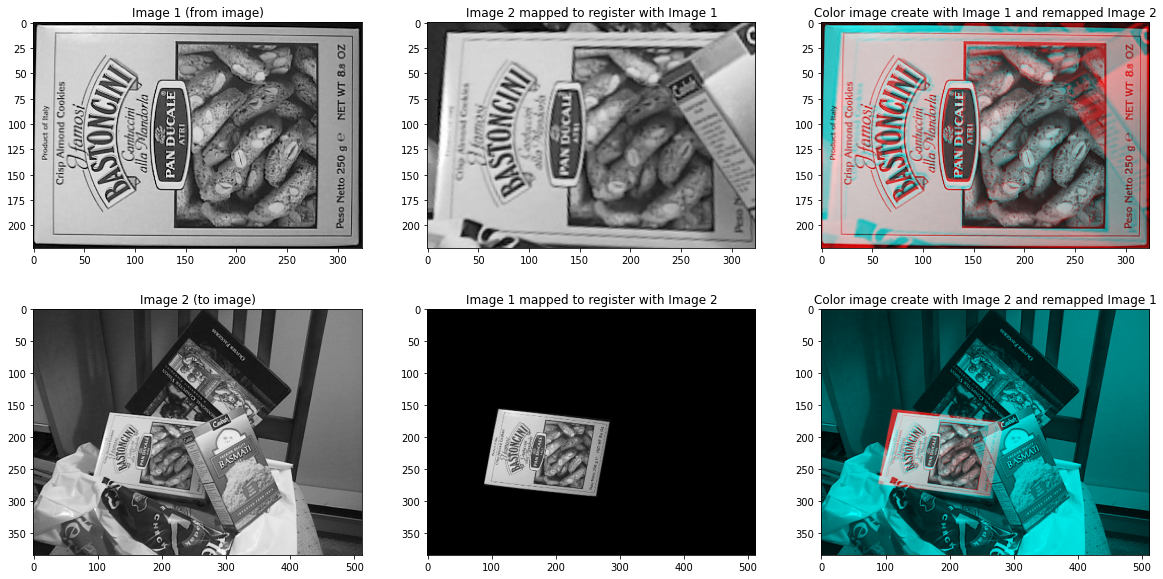

In [ ]:
from skimage.transform import warp

#----------------------------------------------------------------
residual_error, T_affine = fit_affine(X_1, X_2)
#----------------------------------------------------------------

#----------------------------Display----------------------------
T_affine_inv = np.linalg.inv(T_affine)
print('Residual error={}\n T =\n{}\n T_inv =\n{}'.format(residual_error, T_affine, T_affine_inv))

warped_1_into_2 = warp(image_1, inverse_map=T_affine_inv, output_shape=image_2.shape)

warped_2_into_1 = warp(image_2, inverse_map=T_affine, output_shape=image_1.shape)

# build an RGB image with the registered images -- should be white if match is perfect
seq_im_1_into_2 = np.zeros((image_2.shape[0], image_2.shape[1], 3))
seq_im_1_into_2[..., 0] = warped_1_into_2
seq_im_1_into_2[..., 1] = image_2/255
seq_im_1_into_2[..., 2] = image_2/255

seq_im_2_into_1 = np.zeros((image_1.shape[0], image_1.shape[1], 3))
seq_im_2_into_1[..., 0] = warped_2_into_1
seq_im_2_into_1[..., 1] = image_1/255
seq_im_2_into_1[..., 2] = image_1/255


plt.figure(figsize = (20, 10))
plt.subplot(2,3,1)
plt.imshow(image_1, 'gray')
plt.title('Image 1 (from image)')

plt.subplot(2,3,2)
plt.imshow(warped_2_into_1, 'gray')
plt.title('Image 2 mapped to register with Image 1')

plt.subplot(2,3,3)
plt.imshow(seq_im_2_into_1, 'gray')
plt.title('Color image create with Image 1 and remapped Image 2')


plt.subplot(2,3,4)
plt.imshow(image_2, 'gray')
plt.title('Image 2 (to image)')

plt.subplot(2,3,5)
plt.imshow(warped_1_into_2, 'gray')
plt.title('Image 1 mapped to register with Image 2')

plt.subplot(2,3,6)
plt.imshow(seq_im_1_into_2, 'gray')
plt.title('Color image create with Image 2 and remapped Image 1');


# Assignment -- Sensitivity to outlier matches


Change the number of matches (NUM_MATCHES) selected from 8 to 10 to 20 and document the effect observed. Do you have any suggestions for performing estimation in the presence of outlier (wrong) matches)?

# Progressive Outlier removal

The robust statistics field has many mathematically sound ways for estimation in the presence of outliers, such as M-estimators, weighted linear analysis, etc. We can modify the estimation problem to identify the erroneous outlier matches and weigh them down in the estimation process. For a broader introduction to this topic, see https://en.wikipedia.org/wiki/Robust_regression and the references therein.

Here we have implemented a rather greedy (and computationally costly) approach to identifying outlier matches one at a time. In the code, we mark a match for removal using a diagonal weight matrix whose diagonal values are 1 (if the match is included) and 0 (if they are excluded). We identify the match with the largest residual in each iteration and mark it for removal from estimation. We stop when the change in total residual is below a certain percentage change threshold.



## Code: Progressive outlier removal

In [ ]:
def fit_affine_remove_outliers (Points_1, Points_2, acceptable_error = 2) :
    # input: two 2D points sets, each of size N by 2
    # output: residual of fit and the best fitting affine transformation
    # acceptable_error - amount of average pixel error that is acceptable

    # Rearrange the points in 3 by N arrays of homogeneous representation of the points
    X = np.row_stack((Points_1.transpose(1,0), np.ones((1, Points_1.shape[0]))))
    X_dash = np.row_stack((Points_2.transpose(1,0), np.ones((1, Points_2.shape[0]))))
    
    weights = np.eye(X.shape[1])
    average_residual_error = np.sqrt(np.sum(np.power(X - X_dash, 2)/X.shape[1]))
    max_index = -1 #outlier match index to remove
    while average_residual_error > acceptable_error :
        # Compute the matrix H from the point coordinate moments
        M = X @ weights @ X.transpose(1,0)
        A1 = np.column_stack((M, np.zeros((3,3))))
        A2 = np.column_stack((np.zeros((3,3)), M))
        A = np.row_stack((A1, A2))
        #print('A =\n', A)

        # vector b
        b_dash = X @ weights @(X_dash - X).transpose(1,0)
        b = np.row_stack((b_dash[:,0][:,None], b_dash[:,1][:,None]))
        #print('b =\n', b)

        p = qr_solve (A, b) 

        p = p.squeeze()
        # the parameter vector is [a_00, a_01, t_x, a_10, a_11, t_y]
        # rearrange it back into homogeneous matrix representation
        T_affine = np.row_stack((p.reshape(2, 3), [0, 0, 0])) + np.eye(3)
        T_affine_inv = np.linalg.inv(T_affine)

        X_t = T_affine @ X
        error =  (X_dash - X_t) @ weights
        residual_error = np.sum(np.power(error, 2), axis=0)
        average_residual_error = np.sqrt(np.sum(residual_error)/np.sum(weights))
        selected_matches = np.diag(weights).copy()  # diag return the variable by reference so have to copy
        if max_index >= 0 :
            print('residual error = {}, remove outlier match # {}'.format(average_residual_error, max_index))

        # Identify the largest outlier and remove it by setting weight to 0
        max_index = np.argmax(residual_error)
        weights[max_index, max_index] = 0

    return(average_residual_error, T_affine, selected_matches)

## Code: Illustration of outlier removal using image pairs

residual error = 0.6524906103618522, remove outlier match # 8
Selected match flags: [1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Residual error=0.6524906103618522
 T =
[[  0.54  -0.09 110.59]
 [  0.07   0.53 154.25]
 [  0.     0.     1.  ]]
 T_inv =
[[   1.82    0.32 -250.92]
 [  -0.23    1.84 -258.34]
 [   0.      0.      1.  ]]


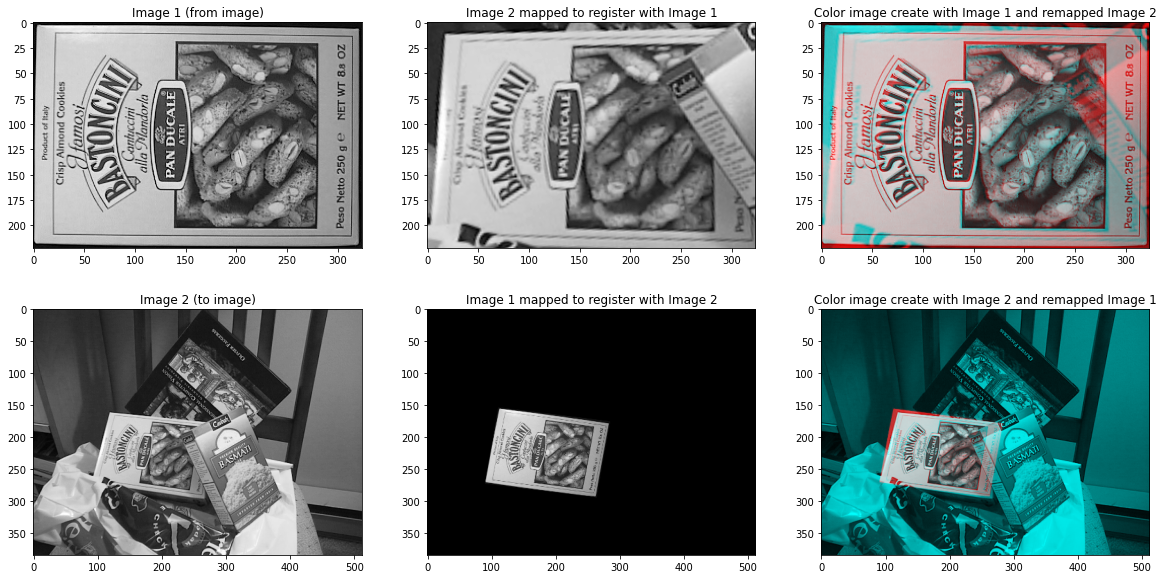

In [ ]:
from skimage.transform import warp

#-------------------------------------------------------------------------
residual_error, T_affine, selected_matches = fit_affine_remove_outliers(X_1, X_2, acceptable_error=5)

print('Selected match flags:', selected_matches)

#---------------------------Display--------------------------------------
T_affine_inv = np.linalg.inv(T_affine)
print('Residual error={}\n T =\n{}\n T_inv =\n{}'.format(residual_error, T_affine, T_affine_inv))

warped_1_into_2 = warp(image_1, inverse_map=T_affine_inv, output_shape=image_2.shape)

warped_2_into_1 = warp(image_2, inverse_map=T_affine, output_shape=image_1.shape)

# build an RGB image with the registered images -- should be white if match is perfect
seq_im_1_into_2 = np.zeros((image_2.shape[0], image_2.shape[1], 3))
seq_im_1_into_2[..., 0] = warped_1_into_2
seq_im_1_into_2[..., 1] = image_2/255
seq_im_1_into_2[..., 2] = image_2/255

seq_im_2_into_1 = np.zeros((image_1.shape[0], image_1.shape[1], 3))
seq_im_2_into_1[..., 0] = warped_2_into_1
seq_im_2_into_1[..., 1] = image_1/255
seq_im_2_into_1[..., 2] = image_1/255


plt.figure(figsize = (20, 10))
plt.subplot(2,3,1)
plt.imshow(image_1, 'gray')
plt.title('Image 1 (from image)')

plt.subplot(2,3,2)
plt.imshow(warped_2_into_1, 'gray')
plt.title('Image 2 mapped to register with Image 1')

plt.subplot(2,3,3)
plt.imshow(seq_im_2_into_1, 'gray')
plt.title('Color image create with Image 1 and remapped Image 2')

plt.subplot(2,3,4)
plt.imshow(image_2, 'gray')
plt.title('Image 2 (to image)')

plt.subplot(2,3,5)
plt.imshow(warped_1_into_2, 'gray')
plt.title('Image 1 mapped to register with Image 2')

plt.subplot(2,3,6)
plt.imshow(seq_im_1_into_2, 'gray')
plt.title('Color image create with Image 2 and remapped Image 1');
